# DIRECTi tutorial

In [1]:
import warnings
import anndata
import scanpy as sc
import Cell_BLAST as cb

warnings.simplefilter("ignore")
cb.config.RANDOM_SEED = 0

## Load data

In this tutorial, we demonstrate how to train DIRECTi models used by Cell BLAST.

Let's first load a dataset [Baron_human](http://download.gao-lab.org/Cell_BLAST/tutorial/Baron_human.h5ad) (*Baron, M. et al., Cell Syst, 2016*), which profiles >8,000 human pancreatic islet cells.

In [2]:
baron_human = anndata.read_h5ad("Baron_human.h5ad")

In [3]:
baron_human.obs.head()

,donor,cell_type1,library,organism,dataset_name,platform,organ,data_type,cell_ontology_class,cell_ontology_id,n_genes,n_counts,__libsize__
cell_id,,,,,,,,,,,,,
human1_lib1.final_cell_0001,1,acinar,lib1,Homo sapiens,Baron_human,inDrop,Pancreas,raw,pancreatic acinar cell,CL:0002064,3526,22412,22412.0
human1_lib1.final_cell_0002,1,acinar,lib1,Homo sapiens,Baron_human,inDrop,Pancreas,raw,pancreatic acinar cell,CL:0002064,4201,27953,27953.0
human1_lib1.final_cell_0003,1,acinar,lib1,Homo sapiens,Baron_human,inDrop,Pancreas,raw,pancreatic acinar cell,CL:0002064,2119,16895,16895.0
human1_lib1.final_cell_0004,1,acinar,lib1,Homo sapiens,Baron_human,inDrop,Pancreas,raw,pancreatic acinar cell,CL:0002064,2956,19300,19300.0
human1_lib1.final_cell_0005,1,acinar,lib1,Homo sapiens,Baron_human,inDrop,Pancreas,raw,pancreatic acinar cell,CL:0002064,2715,15067,15067.0


## Gene selection

The first step is to select most informative genes which cover most of the data variation. Gene selection can be performed using the [find_variable_genes()](modules/Cell_BLAST.data.rst#Cell_BLAST.data.find_variable_genes) function, which is a reimplementation of the `FindVariableGenes()` function in Seurat v2.

In addition to the basic functionality in the Seurat function, we also support gene selection on different "batches" of the data, and merging selected genes from individual "batches" via a voting strategy. This helps filtering out batch effect related genes. E.g., to mitigate batch effect among 4 different donors in the pancreatic dataset, we specify the grouping variable "donor" (column in the `obs` data frame), and leave other parameters as default:

In [4]:
%%capture
axes = cb.data.find_variable_genes(baron_human, grouping="donor")

In [5]:
baron_human.var["variable_genes"].sum()

769

The gene selection result is by default stored in the "variable_genes" column in the `var` data frame, as a boolean mask.

By default, genes selected in 50% of the "batches" will be preserved, which is controlled by the `min_group_frac` parameter. In cases where cell type composition varies considerably across "batches", it might be helpful to reduce the `min_group_frac` cutoff.

## Unsupervised dimension reduction

Now we build and fit a DIRECTi model (for Cell BLAST) with the one-step [fit_DIRECTi()](modules/Cell_BLAST.directi.rst#Cell_BLAST.directi.fit_DIRECTi) function.

Note that we passed the raw data and previously selected genes directly. The function will handle data normalization and gene subsetting internally. Performing data normalization or genes subsetting externally beforehand is **NOT** recommended.

Also, we set the cell embedding dimensionality to 10, and use a 20-dimensional categorical latent *c*.

> Note that though 20-dimensional categorical latent was used, less clusters are formed in the embedding space. This is because the model is flexible to discard categories or to use multiple categories to represent the same cluster if a redundant number of categories is specified. If the data contains one single continuous spectrum of cell states, it can be more appropriate to set `cat_dim` to `None`.

In [6]:
%%capture
model = cb.directi.fit_DIRECTi(
    baron_human, genes=baron_human.var.query("variable_genes").index,
    latent_dim=10, cat_dim=20
)

[INFO] Cell BLAST: Using model path: /tmp/tmpg8lmk1mv


After model training, we can project cells into the cell embedding space using the [inference()](modules/Cell_BLAST.directi.rst#Cell_BLAST.directi.DIRECTi.inference) method.

In [7]:
baron_human.obsm["X_latent"] = model.inference(baron_human)

In [8]:
sc.pp.neighbors(baron_human, use_rep="X_latent")
sc.tl.umap(baron_human)

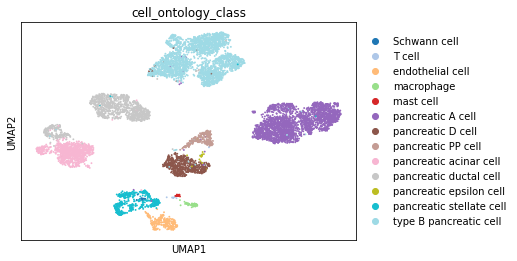

In [9]:
sc.pl.umap(baron_human, color="cell_ontology_class", palette="tab20")

We see that different cell types can readily be distinguished.

This is the prerequisite to successful cell querying. If certain cell types are largely intermingled at this step, they are unlikely to be unambiguously predicted. It might be useful to reconsider the feature selection step or model hyperparameter setting (see function documentation of [find_variable_genes()](modules/Cell_BLAST.data.rst#Cell_BLAST.data.find_variable_genes) and [fit_DIRECTi()](modules/Cell_BLAST.directi.rst#Cell_BLAST.directi.fit_DIRECTi) for details).

You can also save the model for future use via the [save()](modules/Cell_BLAST.directi.rst#Cell_BLAST.directi.DIRECTi.save) method. It is straightforward to load a saved model via the [load()](modules/Cell_BLAST.directi.rst#Cell_BLAST.directi.DIRECTi.load) method.

In [10]:
model.save("./baron_human_model")
del model
model = cb.directi.DIRECTi.load("./baron_human_model")

[INFO] Cell BLAST: Using model path: ./baron_human_model


We can also project other datasets using the same model. Here we test with the [Muraro](http://download.gao-lab.org/Cell_BLAST/tutorial/Muraro.h5ad) dataset (*Muraro, M. et al., Cell Systems, 2016*), which also profiled human pancreatic islets.

Note that we also do not normalize the dataset or subset genes beforehand, as these are handled by the [inference()](modules/Cell_BLAST.directi.rst#Cell_BLAST.directi.DIRECTi.inference) method internally.

Also, there will be a warning saying that we have some genes missing in the new dataset, but it doesn't really matter as long as the number is small. Distinct cell types are still well separated.

In [11]:
muraro = anndata.read_h5ad("Muraro.h5ad")
muraro.obsm["X_latent"] = model.inference(muraro)

[WARNING] Cell BLAST: 18 out of 769 variables are not found, will be set to zero!
[INFO] Cell BLAST: 'ACKR3', 'ADGRF5', 'ADGRL4', 'ADIRF', 'CEMIP', 'CXCL8', 'HLA.B', 'HLA.DPA1', 'HLA.DPB1', 'HLA.DRA', 'HLA.DRB1', 'IL3RA', 'MIR4435.2HG', 'PCAT19', 'PRSS2', 'SDCBP2', 'SMIM24', 'pk'


In [12]:
sc.pp.neighbors(muraro, use_rep="X_latent")
sc.tl.umap(muraro)

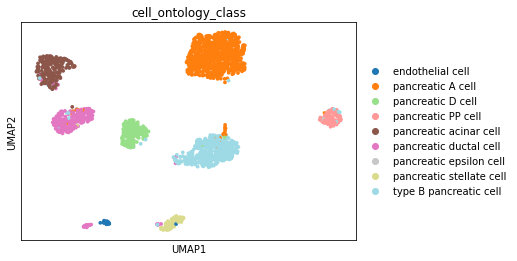

In [13]:
sc.pl.umap(muraro, color="cell_ontology_class", palette="tab20")

## Batch effect correction

Now we demonstrate the function of batch effect correction by training models on a "meta-dataset" merged from [Baron_human](http://download.gao-lab.org/Cell_BLAST/tutorial/Baron_human.h5ad), [Segerstolpe](http://download.gao-lab.org/Cell_BLAST/tutorial/Segerstolpe.h5ad), [Muraro](http://download.gao-lab.org/Cell_BLAST/tutorial/Muraro.h5ad), [Xin_2016](http://download.gao-lab.org/Cell_BLAST/tutorial/Xin_2016.h5ad) & [Lawlor](http://download.gao-lab.org/Cell_BLAST/tutorial/Lawlor.h5ad) (all profiling human pancreatic islets), where we expect significant batch effect among different datasets.

We first merge different datasets using the [anndata.AnnData.concatenate()](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.concatenate.html) function.

In [14]:
combined_adata = anndata.AnnData.concatenate(
    anndata.read_h5ad("Baron_human.h5ad"),
    anndata.read_h5ad("Segerstolpe.h5ad"),
    anndata.read_h5ad("Muraro.h5ad"),
    anndata.read_h5ad("Xin_2016.h5ad"),
    anndata.read_h5ad("Lawlor.h5ad"),
    join="outer", batch_key="study", batch_categories=["Baron_human", "Segerstolpe", "Muraro", "Xin_2016", "Lawlor"]
)

In [15]:
%%capture
axes = cb.data.find_variable_genes(combined_adata, grouping="study", min_group_frac=0.4)

In [16]:
combined_adata.var["variable_genes"].sum()

827

We first train a model on the "meta-dataset" without batch effect correction, and validate that significant batch effect exists among different datasets.

In [17]:
%%capture
model = cb.directi.fit_DIRECTi(
    combined_adata, genes=combined_adata.var.query("variable_genes").index,
    latent_dim=10, cat_dim=20
)
combined_adata.obsm["X_latent"] = model.inference(combined_adata)

[INFO] Cell BLAST: Using model path: /tmp/tmpfcy7h184


In [18]:
sc.pp.neighbors(combined_adata, use_rep="X_latent")
sc.tl.umap(combined_adata)

... storing 'cell_type1' as categorical
... storing 'dataset_name' as categorical
... storing 'platform' as categorical
... storing 'data_type' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'age' as categorical
... storing 'gender' as categorical
... storing 'race' as categorical
... storing 'gene_id-Lawlor' as categorical


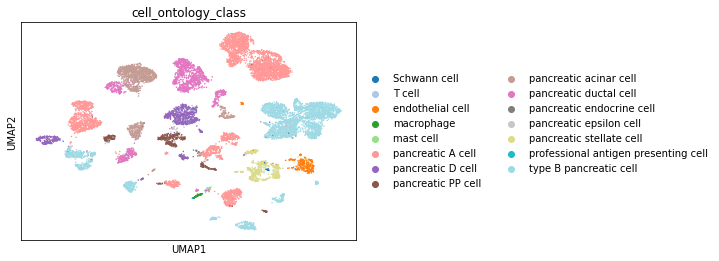

In [19]:
sc.pl.umap(combined_adata, color="cell_ontology_class", palette="tab20")

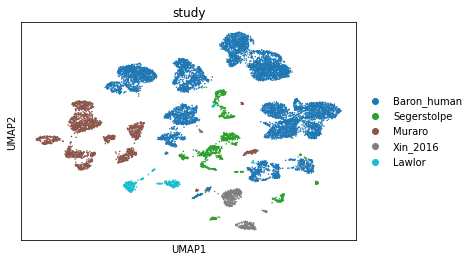

In [20]:
sc.pl.umap(combined_adata, color="study", palette="tab10")

To perform batch effect correction, specify `batch_effect` as a column in the `obs` slot corresponding to the batch indicator, which is "study" in this case.

In [21]:
%%capture
model_rmbatch = cb.directi.fit_DIRECTi(
    combined_adata, genes=combined_adata.var.query("variable_genes").index.to_numpy(),
    batch_effect="study", latent_dim=10, cat_dim=20
)
combined_adata.obsm["X_latent"] = model_rmbatch.inference(combined_adata)

[INFO] Cell BLAST: Using model path: /tmp/tmpi4pk9nxe


We see that batch effect is largely removed in the embedding space. Cells of the same cell type from different studies are well aligned.

In [22]:
sc.pp.neighbors(combined_adata, use_rep="X_latent")
sc.tl.umap(combined_adata)

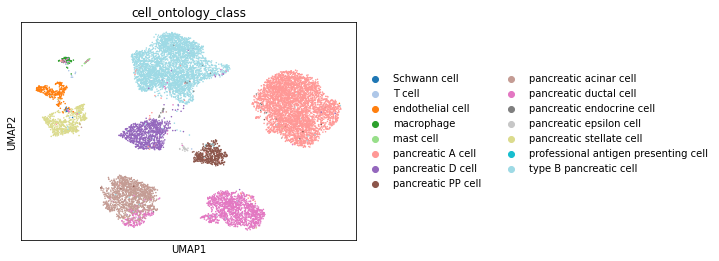

In [23]:
sc.pl.umap(combined_adata, color="cell_ontology_class", palette="tab20")

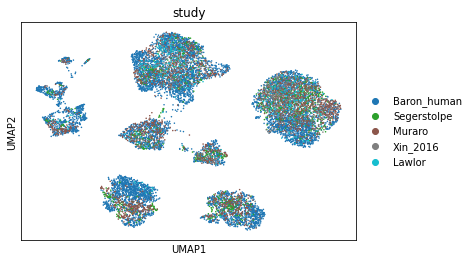

In [24]:
sc.pl.umap(combined_adata, color="study", palette="tab10")